This code is for learning MCMC, comparison between data and theory
following the instruction of https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

Starting with Bayesian theorem, given data, the probability of our model (posterior probability) is
\begin{align}
        \begin{split}
            P(model|data) = \frac{P(data|model) P(model)}{P(data)}.
        \end{split}
    \end{align}
    
Or we can rewrite it as
     \begin{align}
        \begin{split}
            P(\theta|D) = \frac{P(D|\theta) P(\theta)}{P(D)}.
        \end{split}
    \end{align}
    
- "MCMCs are a class of methods that most broadly are used to numerically perform multidimensional integrals. However, it is fully true that these methods are highly useful for the practice of inference; that is, fitting models to data." 

- "MCMC allows us to obtain better, more robust uncertainties on your parameters, to understand multi-modalities or covariances in your data, and marginalize out nuisance parameters that you don’t care about, but nevertheless need to include in your modeling to obtain accurate results."

- "The fundamental process of running an MCMC: to compare generated models against data. Those models are generated by a set of parameters, and our goal: to sample from the set of parameters that produces the models that well-fit our data."

- MCMC allow us to estimate the posterior distribution (LHS) by numerically integrating the RHS, for some given expectation value

\begin{align}
    E(\theta) = \int \theta p(\theta) d\theta \approx \frac{1}{N} \sum_i^N \theta_i,
\end{align}

or for any function of $\theta$

\begin{align}
    E(g(\theta)) = \int g(\theta) p(\theta) d\theta,
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import emcee

In [3]:
import corner

In [4]:
path='/home/ngoc/Downloads/GCs/ipynb/testMCMC/'

In [5]:
age   = np.loadtxt(path+'data.txt', usecols=(2))
temp  = np.loadtxt(path+'data.txt', usecols=(4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


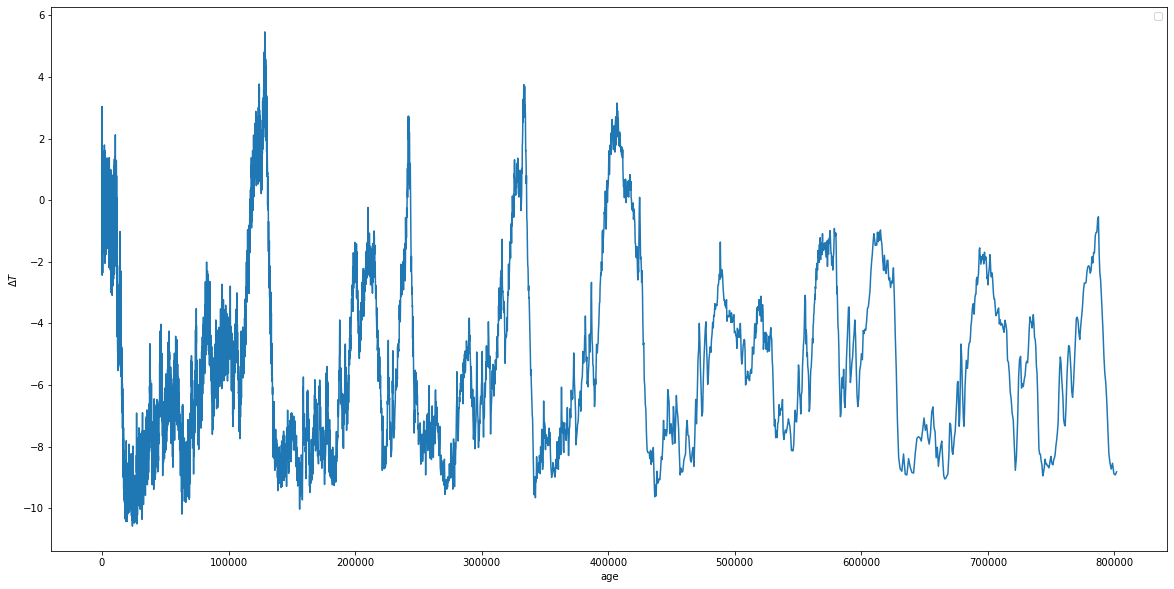

In [7]:
# example of fitting Earth;s Milankovich cycles
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)
plt.plot(age,temp)
plt.xlabel('age')
plt.ylabel('$\Delta T$')
plt.legend()

We first describe a model 

\begin{align}
    \Delta T = a_1 \sin (2\pi t/p_1) + a_2 \sin (2\pi t/p_2) + a_3 \sin (2\pi t/p_3) + T_0,
\end{align}

where $a_1, a_2, a_3, p_1, p_2, p_3, T_0$ are the parameters we want to fit.

In [8]:
def model(theta, age = age):
    a1, a2, a3, p1, p2, p3, T0 = theta  #parameters in the model
    model = a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0
    return model

define a function that return how good a fit our model is to the data, for the given set of parameters, weighted by the error in the data points (simple $\chi^2$ type check). 

\begin{align}
    L_{lnlike} = -0.5\sum (\frac{y-y_{model}}{y_{err}})^2
\end{align}

- If the new model returns better fit compare to the default model (by an acceptance ratio), the walker will move toward that and repeat the process.

- Every walker keeps a record of $\theta$ and the likelihood of the model given data at value $\theta$.

- As if MCMC runs long enough to converge, it represents a sample of reasonable models to describe the data;



In [20]:
def lnlike(theta, x, y, yerr):
    lnlike = -0.5*np.sum(((y-model(theta,x))/yerr)**2)
    return lnlike

In [21]:
# the things we know (fact/conditions to the parameters)
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
         return 0.0
    else:
        return -np.inf

In [22]:
# the function as lnprior output + lnlike output
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Note that data needs to have errors to run MCMC 

In [23]:
Terr     = 0.05*np.mean(temp) #error of the temperature array, set 5%
data     = (age, temp, Terr)
nwalkers = 128
niter    = 500
initial  = np.array([1., 1., 1., 26000., 41000., 100000., -4.5]) # initial set of values of the parameters (guess)
ndim     = len(initial)

#stepping from one place to the next, generate N-dimensional parameters space close to the current location
p0       = [np.array(initial) + 1e-7*np.random.randn(ndim) for i in range(nwalkers)]

run MCMC

In [24]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [25]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [26]:
def plotter(sampler,age=age,T=temp):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

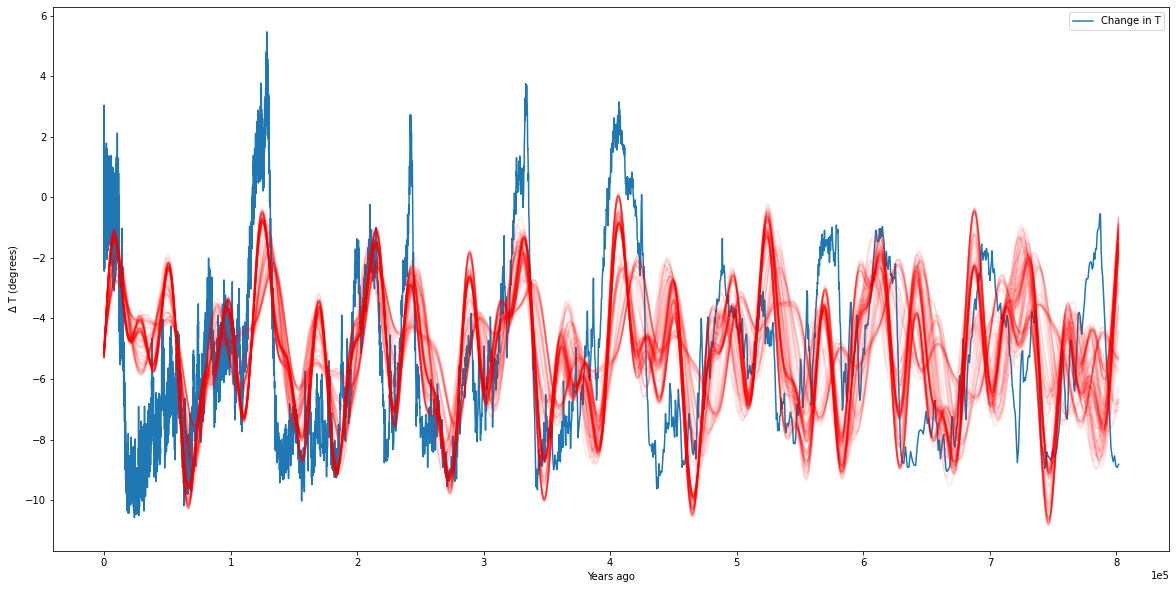

In [27]:
#sampler= main(p0)
plotter(sampler)

In [28]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
#value of each parameter, highest likelihood model 

array([ 1.33303113e+00,  2.06286257e+00,  1.90713469e+00,  2.35244564e+04,
        3.97223077e+04,  9.61865684e+04, -5.24295612e+00])

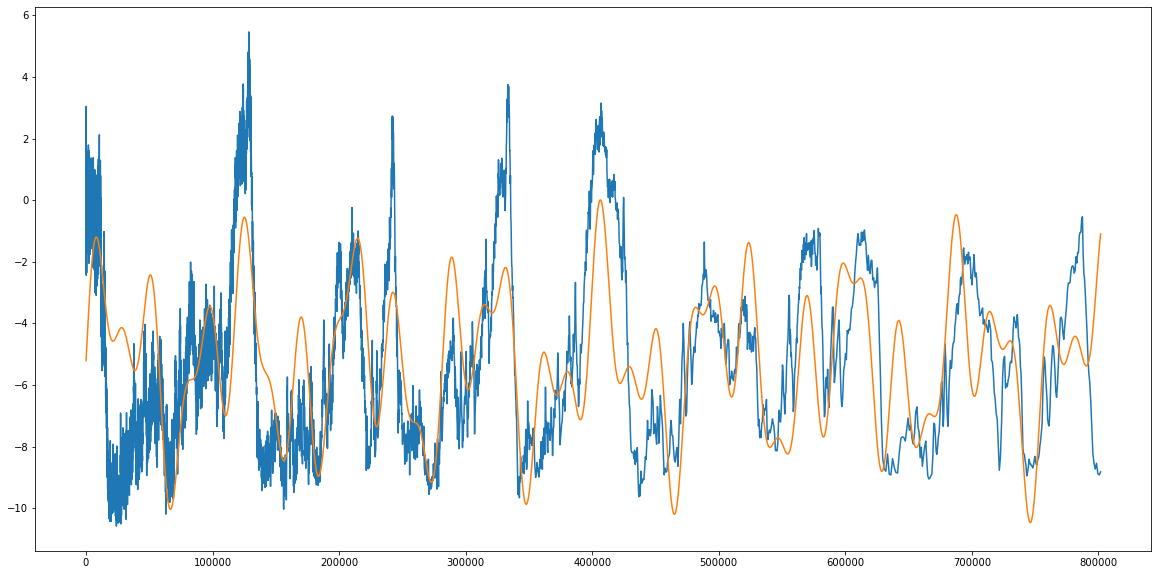

Theta max:  [ 1.33303113e+00  2.06286257e+00  1.90713469e+00  2.35244564e+04
  3.97223077e+04  9.61865684e+04 -5.24295612e+00]


In [29]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,temp,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',theta_max)

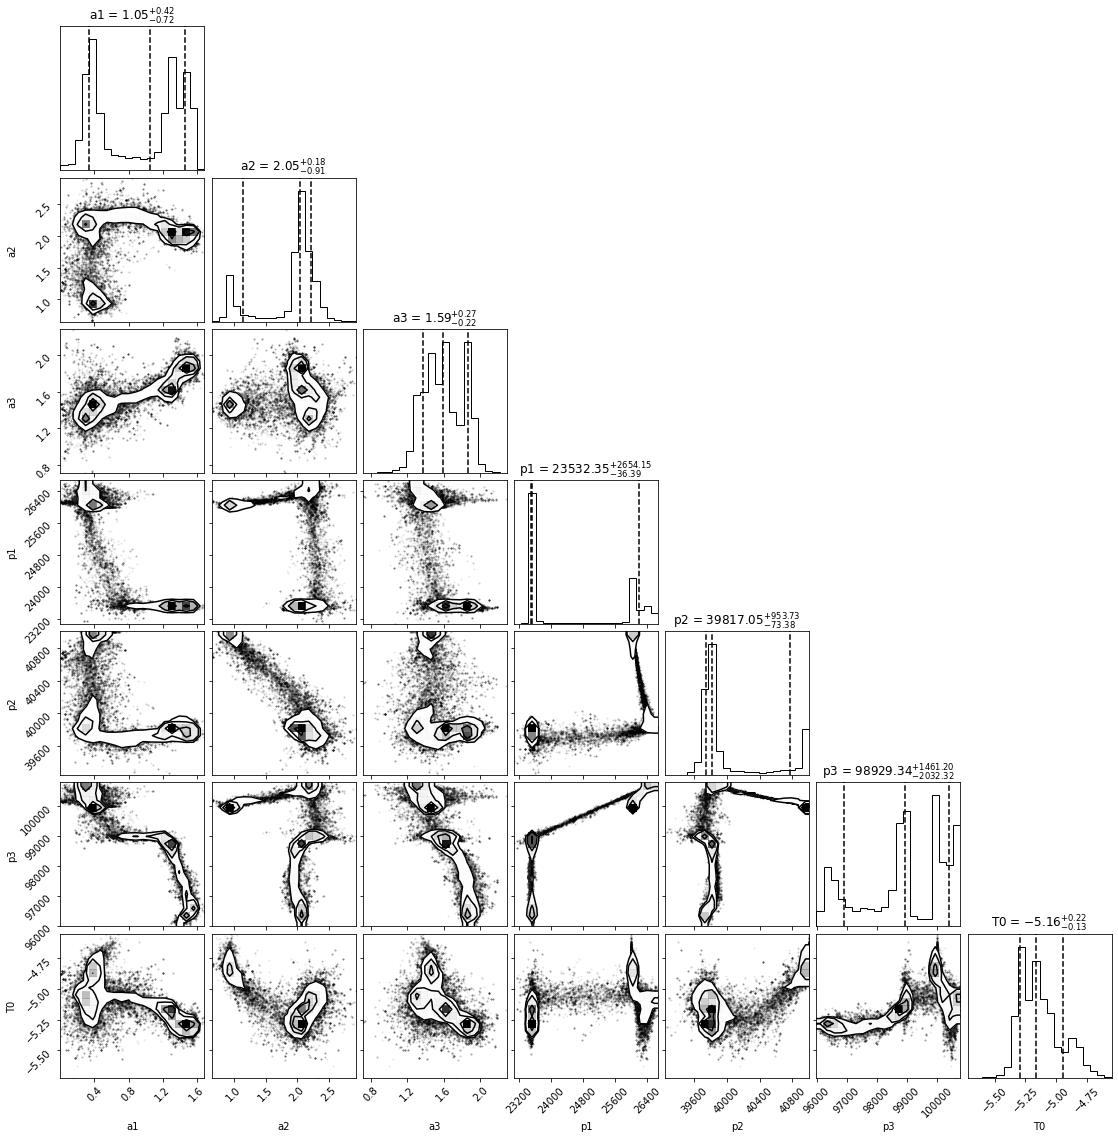

In [30]:
#posterior spread: spreading between the parameters + uncertainties
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True
                    ,quantiles=[0.16, 0.5, 0.84])

- It looks awful with bimodalities and clumps => means we chose a not-good model at the first place.

- Two peaks (e.g in a_1) shows we haven't converged on a single answer.

- More walkers and more iterations could help?

In [32]:
Terr     = 0.05*np.mean(temp)
data     = (age, temp,Terr)
nwalkers = 240     # increase number of walkers and iterations
niter    = 1024
initial  = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim     = len(initial)
p0       = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


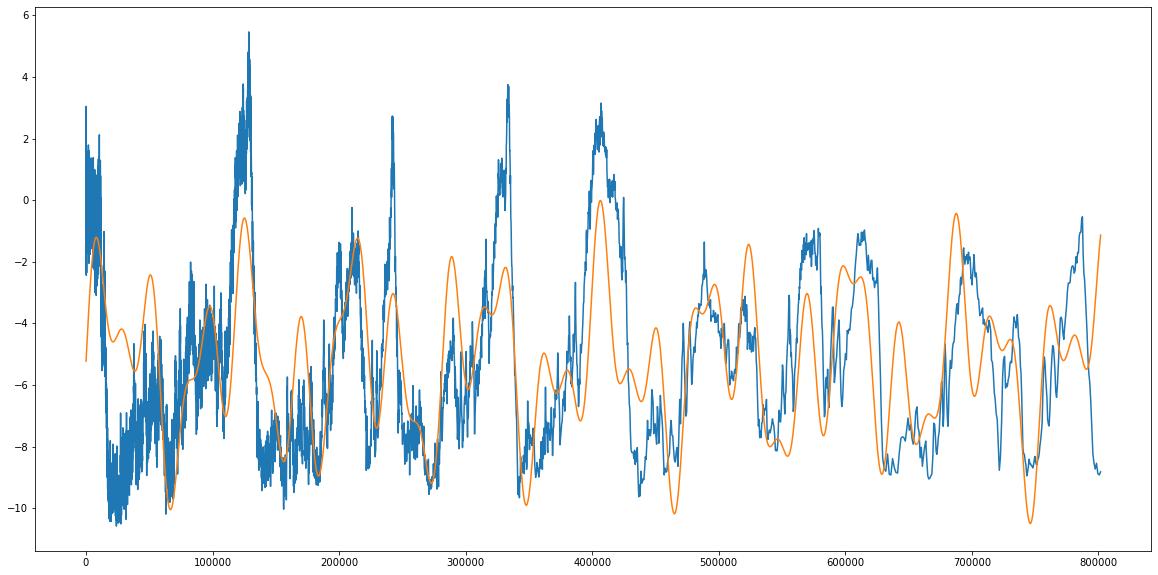

Theta max:  [ 1.32793077e+00  2.07890761e+00  1.89513719e+00  2.35215423e+04
  3.97334327e+04  9.61349246e+04 -5.25631947e+00]


In [34]:
new_samples =  new_sampler.flatchain

new_theta_max      = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,temp,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',new_theta_max)

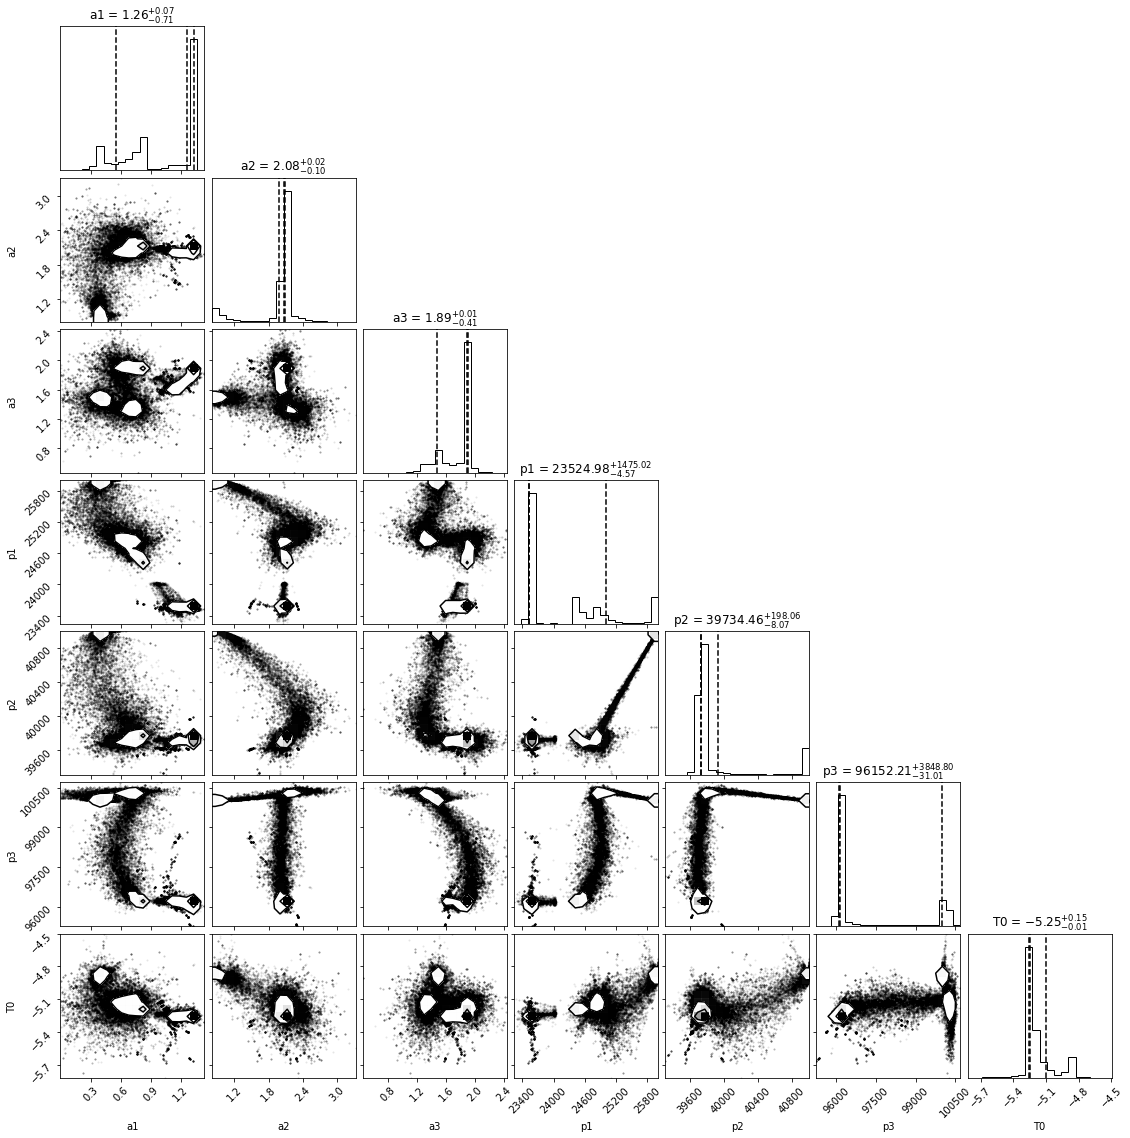

In [35]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [36]:
#plotting a one sigma spread in posteriors over the theta max we plotted
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw   = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

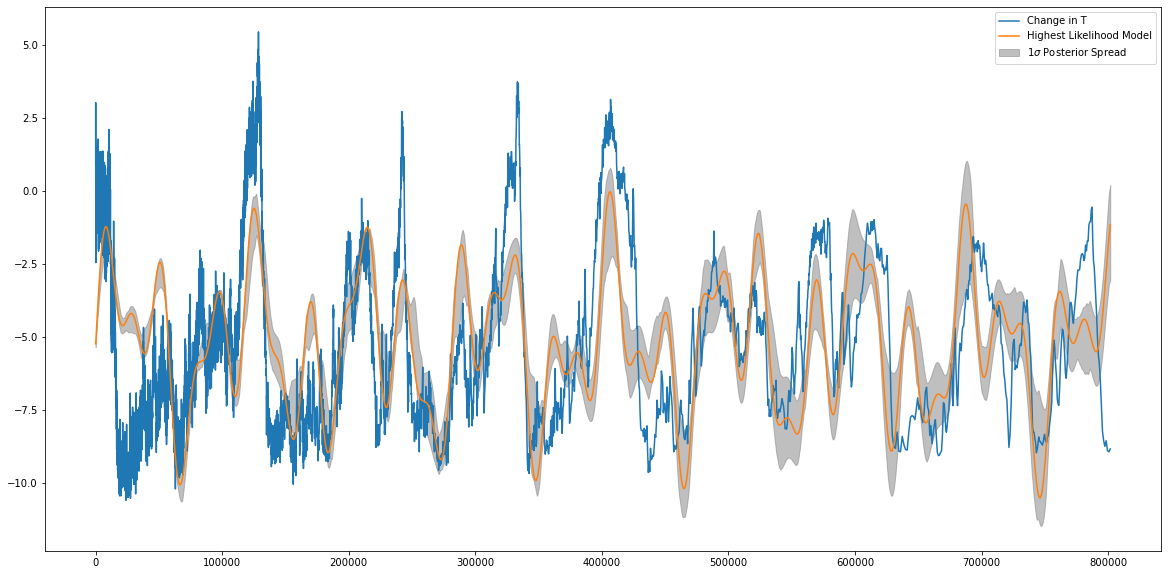

In [37]:
plt.plot(age,temp,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()